In [1]:
# Misc imports
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')
import torch
torch.set_printoptions(linewidth=200)
import seaborn as sns
sns.set_style("darkgrid")
import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
import yaml
from pathlib import Path
# Local imports
from ese.scripts.utils import get_option_product
from ese.experiment.analysis.run_inference import get_cal_stats
from ese.experiment.analysis.ensemble_upperbound import get_ensemble_ub
from ese.experiment.analysis.analysis_utils.submit_utils import get_ese_inference_configs
# Ionpy imports
from ionpy.util import Config
from ionpy.analysis import ResultsLoader

# Define some useful paths.
scratch_root = Path("/storage/vbutoi/scratch/ESE")
code_root = Path("/storage/vbutoi/projects/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml inference_config

log:
    root: '?'
    min_fg_pixels: '?' 
    gether_inference_stats: '?'
    summary_compute_global_metrics: '?' 
    log_interval: 20 
    log_image_stats: True 
    log_pixel_stats: True 
    track_ensemble_member_scores: True 

experiment:
    exp_root: '?'
    seed: 42

data:
    splits: ('val', 'cal')
    preload: False 

dataloader:
    batch_size: 1 
    num_workers: 0
    pin_memory: True 

model:
    calibrator: '?'
    checkpoint: '?' 
    pretrained_exp_root : '?' 
    pretrained_select_metric: "val-dice_score"

<IPython.core.display.Javascript object>

In [3]:
%%yaml ensemble_cfg

ensemble:
    combine_fn: '?'
    combine_quantity: '?'
    member_w_metric: 'None'
    normalize: False

<IPython.core.display.Javascript object>

In [4]:
additional_args = {
    "log.gether_inference_stats": [True],
    "log.summary_compute_global_metrics": [True],
    "data.subsplit": [5]
}

In [5]:
# # Setting 1
# ######################################3
# exp_name = '03_03_24_RandomCircles_Ind2Ind'
# group_dict = {
#     "dataset": "Shapes",
#     "exp_group": exp_name,
#     "base_models_group": "03_02_24_RandomCircles_Independent",
#     "calibrated_models_group": "03_02_24_RandomCircles_Ind2Ind"
# }

# # Setting 2
# ######################################3
# exp_name = '03_03_24_RandomCircles_Ind2Shr'
# group_dict = {
#     "dataset": "Shapes",
#     "exp_group": exp_name,
#     "base_models_group": "03_02_24_RandomCircles_Independent",
#     "calibrated_models_group": "03_02_24_RandomCircles_Ind2Shr"
# }

# Setting 3
######################################3
exp_name = '03_03_24_RandomCircles_Shr2Ind'
group_dict = {
    "dataset": "Shapes",
    "exp_group": exp_name,
    "base_models_group": "03_02_24_RandomCircles_Shared",
    "calibrated_models_group": "03_02_24_RandomCircles_Shr2Ind"
}

# # Setting 4
# ######################################3
# exp_name = '03_03_24_RandomCircles_Shr2Shr'
# group_dict = {
#     "dataset": "Shapes",
#     "exp_group": exp_name,
#     "base_models_group": "03_02_24_RandomCircles_Shared",
#     "calibrated_models_group": "03_02_24_RandomCircles_Shr2Shr"
# }

### Standard Calibrators.

In [6]:
inference_func = get_cal_stats
# Get the configs for the different runs.
option_set = get_ese_inference_configs(
    group_dict=group_dict,
    calibrators_list=[
        'Uncalibrated',
        # 'FT_CE',
        # 'FT_Dice',
        # 'TempScaling',
        # 'NectarScaling',
    ],
    ensemble_opts=[
        True,
        # False
    ], 
    additional_args=additional_args
)

### Binning Calibrators

In [7]:
# do_ensemble = True 
# inference_func = get_cal_stats
# # Get the configs for the different runs.
# option_set = get_ese_inference_configs(
#     group_dict=group_dict,
#     calibrators_list=[
#         'HistogramBinning',
#         'LocalHistogramBinning',
#         'NectarBinning',
#         'SoftNectarBinning'
#     ], 
#     do_ensemble=do_ensemble, 
#     cal_stats_splits=[
#         'val',
#         'cal'
#     ],
#     additional_args=additional_args
# )

### Upper Bounds

In [8]:
# # # Get the configs for computing the upepr bounds
# inference_func = get_ensemble_ub
# option_set = get_ese_inference_configs(
#     group_dict=group_dict,
#     do_ensemble=True, 
#     ensemble_upper_bound=True,
#     calibrators_list=[
#         'Uncalibrated',
#     ], 
#     ens_cfg_options=[
#         ('upperbound', 'probs')
#     ]
# )

In [9]:
# Load the inference cfg from local.
##################################################
inf_cfg_root = code_root / "ese" / "experiment" / "configs" / "inference"

##################################################
with open(inf_cfg_root / f"{group_dict['dataset']}.yaml", 'r') as file:
    dataset_inference_cfg = yaml.safe_load(file)
with open(inf_cfg_root / "Calibration_Metrics.yaml", 'r') as file:
    cal_metrics_cfg = yaml.safe_load(file)

##################################################
base_cfg = Config(inference_config).update([dataset_inference_cfg, cal_metrics_cfg, ensemble_cfg])
# Get the configs
cfgs = get_option_product(exp_name, option_set, base_cfg)

In [10]:
len(cfgs)

2

## Running Jobs

In [11]:
from ese.experiment.analysis.run_inference import get_cal_stats

Set seed: 42


/storage/vbutoi/projects/ionpy/util/libcheck.py:49: UserWarning: Intel MKL extensions not available for NumPy
  warn("Intel MKL extensions not available for NumPy")
/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


  0%|          | 0/6 [00:00<?, ?it/s]

Set seed: 41


/storage/vbutoi/projects/ionpy/util/libcheck.py:49: UserWarning: Intel MKL extensions not available for NumPy
  warn("Intel MKL extensions not available for NumPy")
/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


Set seed: 40
Set seed: 43
Set seed: 42


  0%|          | 0/4 [00:00<?, ?it/s]

Set seed: 42
Running:

data:
  preload: false
  splits: ('val', 'cal')
  subsplit: 5
dataloader:
  batch_size: 1
  num_workers: 0
  pin_memory: true
dataset:
  _class: ese.experiment.datasets.Shapes
  augmentations: null
  binarize: true
  labels:
  - 9
  preload: false
  return_data_id: true
  subsplit: 5
  version: 2.0
ensemble:
  combine_fn: mean
  combine_quantity: probs
  member_w_metric: None
  normalize: false
experiment:
  dataset_name: Shapes
  exp_root: /storage/vbutoi/scratch/ESE/inference/03_03_24_RandomCircles_Shr2Ind
  pretrained_seed: 42
  seed: 42
global_cal_metrics:
- ECE:
    _fn: ese.experiment.metrics.ece.ece_loss
    cal_type: toplabel
- Edge-ECE:
    _fn: ese.experiment.metrics.ece.edge_ece_loss
    cal_type: toplabel
- CW-ECE:
    _fn: ese.experiment.metrics.ece.cw_ece_loss
    cal_type: classwise
    class_weighting: proportional
- ECW-ECE:
    _fn: ese.experiment.metrics.ece.ecw_ece_loss
    cal_type: classwise
    class_weighting: proportional
- Uniform-CW-ECE

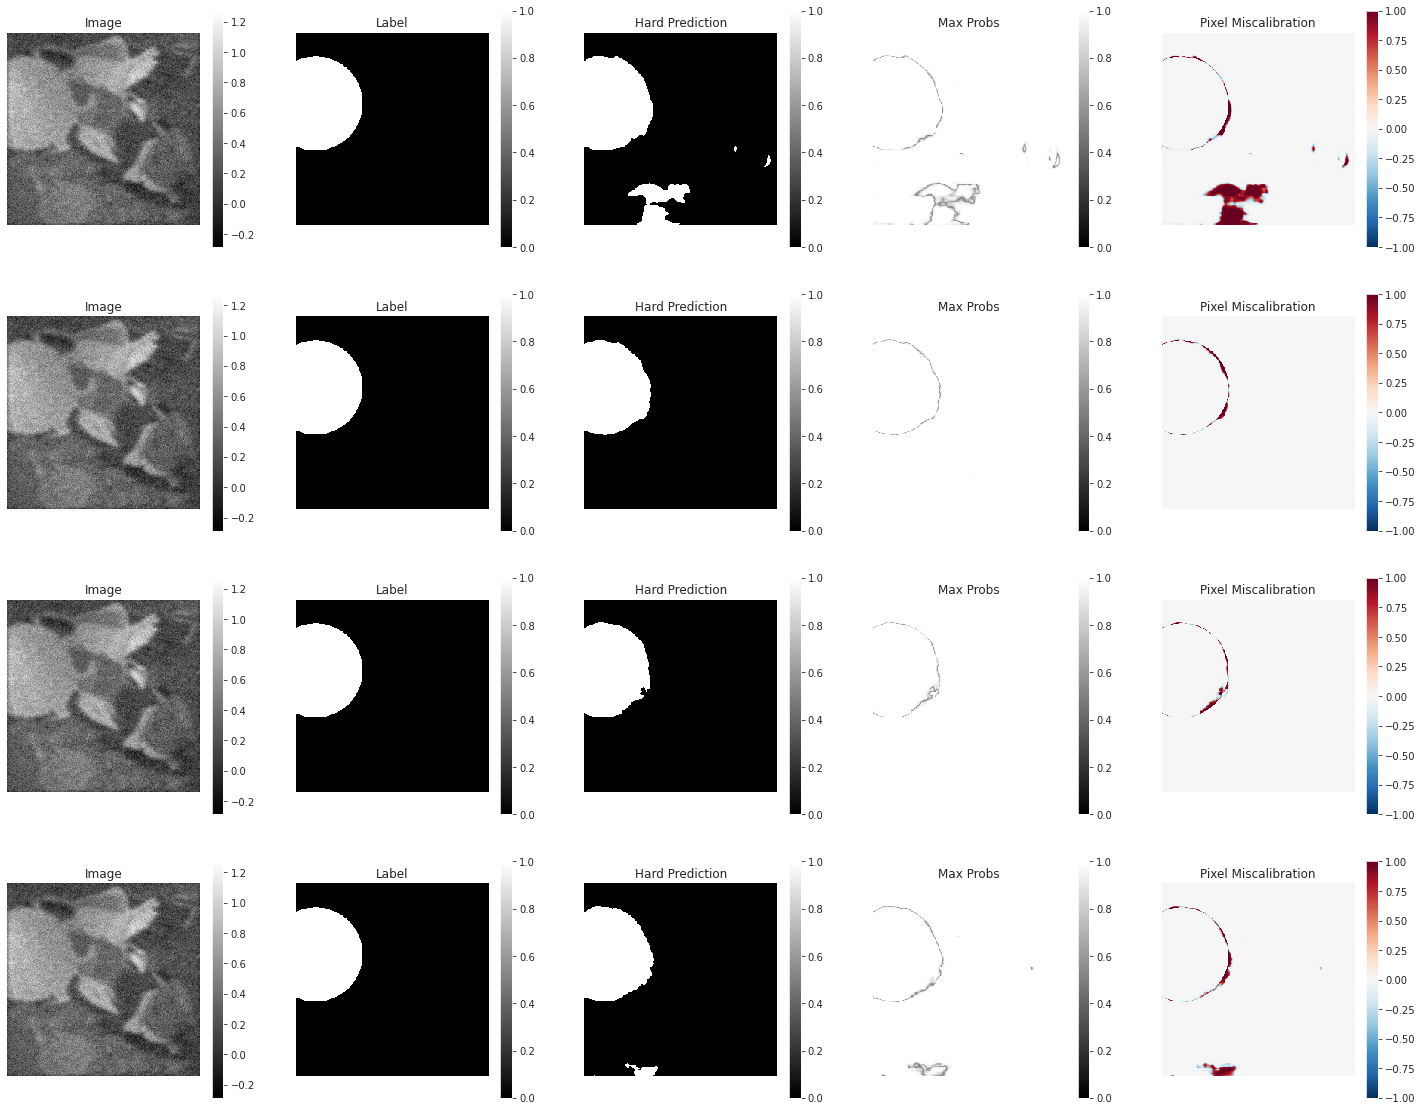

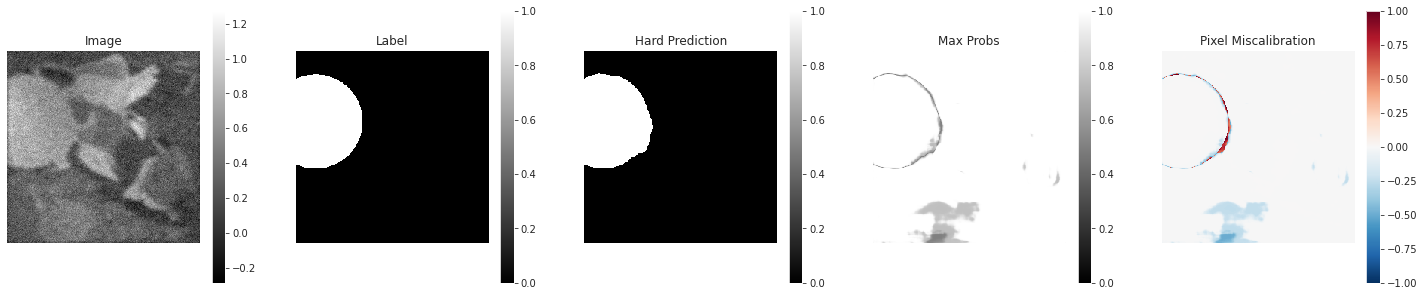

Dice: 0.9840673804283142
HD95: 3.1622776985168457
BoundaryIOU: 0.2690739631652832
Ensemble-VAR: 0.010294218547642231
Ensemble-TOP-VAR: 0.0009949125815182924
Avg-PW Soft-Dice: 0.039507459849119186
Avg-PW Hard-Dice: 0.08306752890348434
Ambiguity: 0.007720663212239742
Image_ECE: 0.01053759373280629
Image_Edge-ECE: 0.09873964217228767
Image_CW-ECE: 0.011513183824717999
Image_ECW-ECE: 0.013945568352937698
Image_Uniform-CW-ECE: 0.011513183824717999
Image_Uniform-ECW-ECE: 0.01222932431846857
Image_ELM: 0.011383955366909504
Image_Edge-ELM: 0.11870256066322327
Image_Uniform-ELM: 0.11482162028551102
Image_Uniform-Edge-ELM: 0.16089433431625366


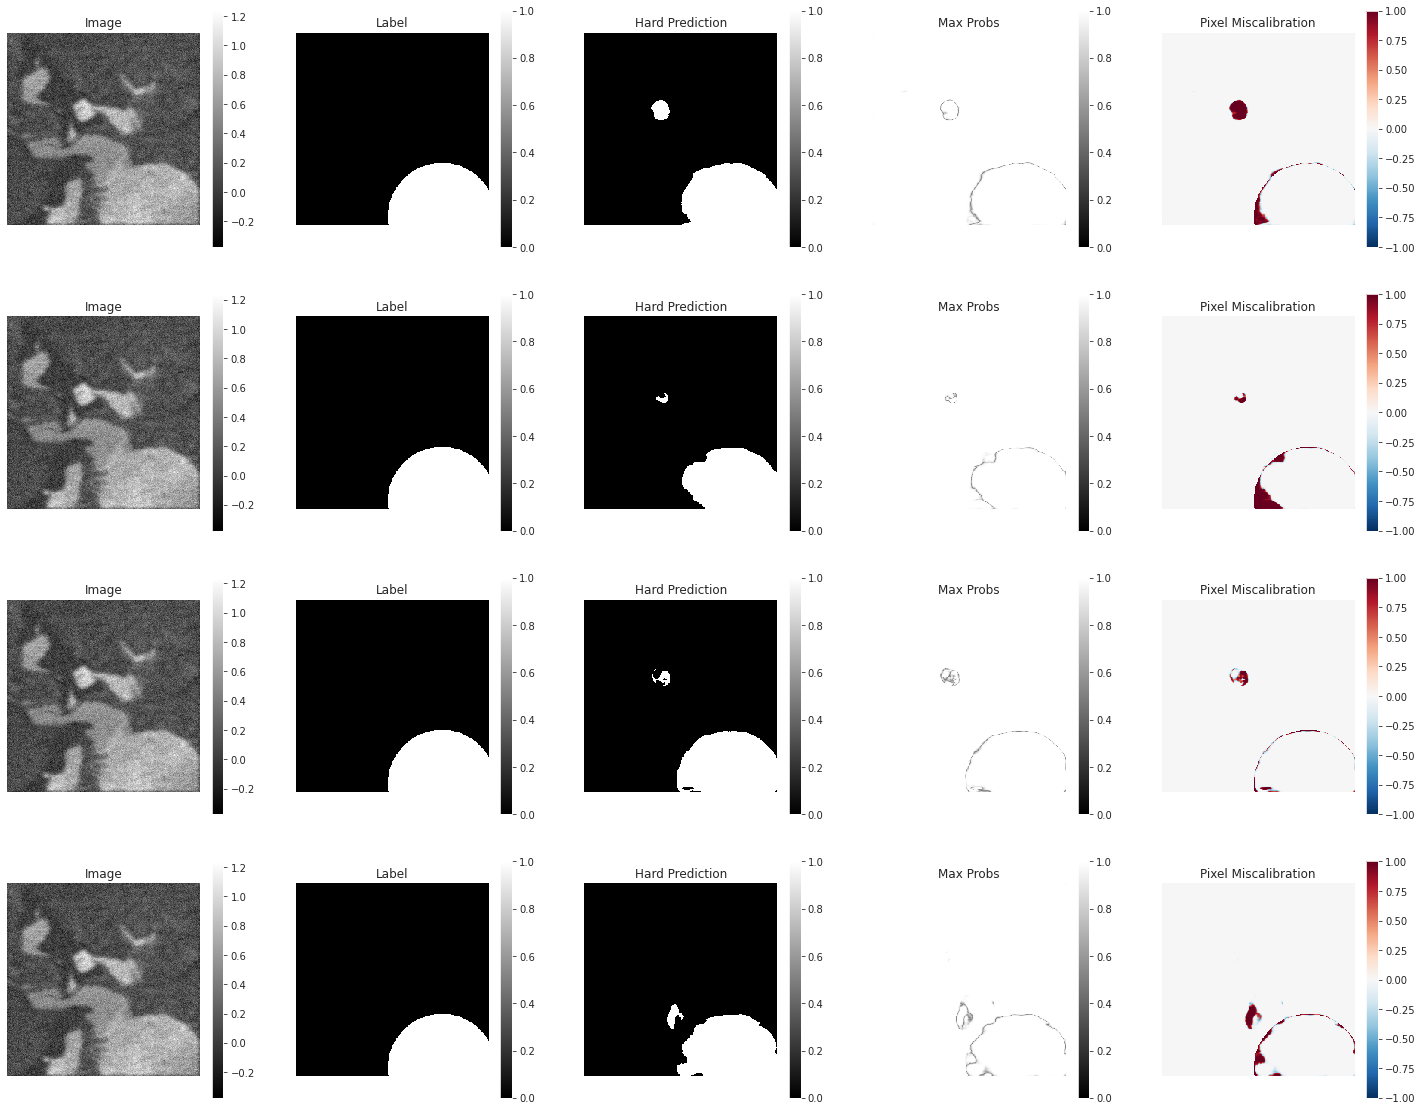

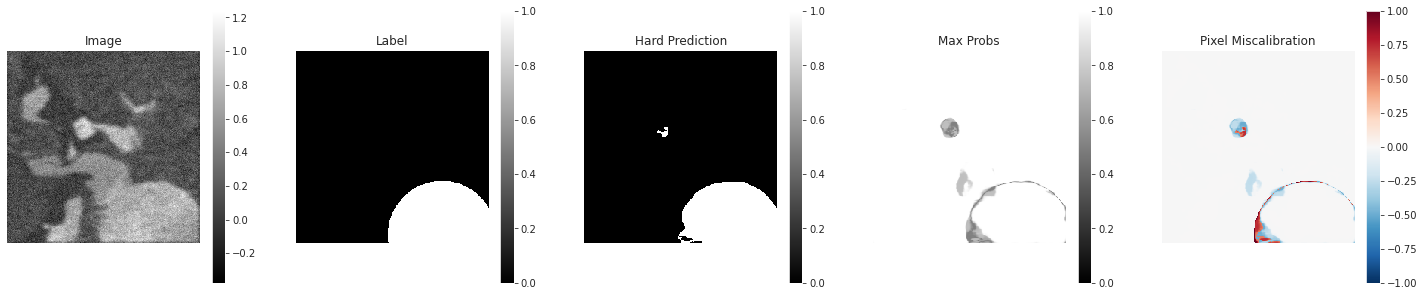

Dice: 0.9708237648010254
HD95: 87.263671875
BoundaryIOU: 0.2117655873298645
Ensemble-VAR: 0.006690371315926313
Ensemble-TOP-VAR: 0.0005907113663852215
Avg-PW Soft-Dice: 0.028458943590521812
Avg-PW Hard-Dice: 0.06090643256902695
Ambiguity: 0.0050177788361907005
Image_ECE: 0.0032347442174796796
Image_Edge-ECE: 0.12253929095135797
Image_CW-ECE: 0.004666355438530445
Image_ECW-ECE: 0.011522876098752022
Image_Uniform-CW-ECE: 0.004666355438530445
Image_Uniform-ECW-ECE: 0.02907685562968254
Image_ELM: 0.0044174701906740665
Image_Edge-ELM: 0.17718687653541565
Image_Uniform-ELM: 0.09896773099899292
Image_Uniform-Edge-ELM: 0.20578652620315552


KeyboardInterrupt: 

In [12]:
from ese.experiment.experiment import run_ese_exp

###### Run individual jobs
run_ese_exp(
    config=cfgs[0], 
    job_func=get_cal_stats,
    run_name='debug',
    show_examples=True,
    gpu='3',
) 

In [ ]:
# from ese.experiment.experiment import submit_ese_exps 

# #### Run Batch Jobs
# submit_ese_exps(
#     config_list=cfgs,
#     job_func=get_cal_stats,
#     available_gpus=['0', '1', '2', '3']
# )